# Import libraries

In [10]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import libs_cpd
import datareader.data as dtest
import models.kalman as kalman
import create_report as crtest
import optimization.functions as optf

In [14]:
import streamlit

In [15]:
streamlit.line_chart?

# Import data

In [11]:
print(dtest.list_links)

['https://storage.yandexcloud.net/cloud-files-public/229G_las_files.csv', 'https://storage.yandexcloud.net/cloud-files-public/231G_las_files.csv', 'https://storage.yandexcloud.net/cloud-files-public/237G_las_files.csv']


In [12]:
df = dtest.df_expirement(dtest.list_links[0])
df.head()

,GR,Resist_long,Resist_short,DrillingSpeed,LITHOLOGY,CPs
time,,,,,,
1970-01-01 00:00:00,126.895,3.616,0.0,26.227,0.0,0.0
1970-01-01 00:00:01,126.466,3.158,0.0,23.762,0.0,0.0
1970-01-01 00:00:02,125.576,2.907,0.0,21.297,0.0,0.0
1970-01-01 00:00:03,127.400,2.863,0.0,21.330,0.0,0.0
1970-01-01 00:00:04,129.225,3.027,0.0,21.363,0.0,0.0


# Preprocessing data

In [4]:
window_length_savgol = libs_cpd.WindowSizeSelection(time_series = list(df.GR),
                                       wss_algorithm = 'summary_statistics_subsequence').get_window_size()[0]
norm_filter_gr = optf.normalization_linear(optf.filter_Savgol(df.Resist_short, window_length_savgol))
window_length = libs_cpd.WindowSizeSelection(time_series = norm_filter_gr,
                                       wss_algorithm = 'dominant_fourier_frequency', window_max=1000, window_min=50).get_window_size()[0]

# Kalman Filter block

In [5]:
cps_list_kalman = kalman.online_detection(list(df['GR']), window=window_length, queue_window=11, treshold_coef=5)
df['cps_kalman'] = cps_list_kalman

# Create report

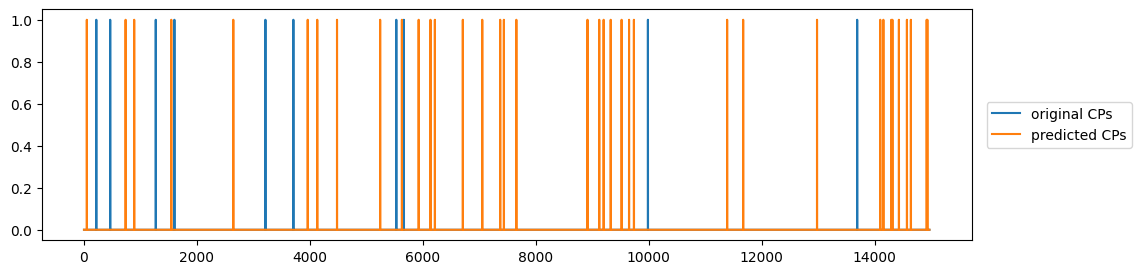

In [6]:
libs_cpd.plt.figure(figsize=(12,3))
libs_cpd.plt.plot(list(df.CPs), label='original CPs')
libs_cpd.plt.plot(cps_list_kalman,label='predicted CPs')
libs_cpd.plt.legend(loc="center right" , bbox_to_anchor=(1.18, 0.5))

In [7]:
%%capture --no-display
tsad_average_results = crtest.tsad_average(df.cps_kalman, df.CPs)

In [8]:
%%capture --no-display
tsad_nab_results = crtest.tsad_nab(df.cps_kalman, df.CPs)

In [9]:
tsad_nab_results.update(tsad_average_results)
crtest.create_report(tsad_nab_results)

,0
Standart,-18.50
LowFP,-37.00
LowFN,-12.33
Time_Delta,0.00
Missed_CP,11.00
FPs,37.00
True_Anomalies_Count,11.00
precision,0.00
recall,0.00
F1,0.00
